In [1]:
import numpy as np
import sympy as spy
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.interpolate import interp1d
%matplotlib inline

spy.init_printing()

# Punto 1

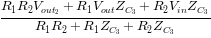

V_B = \frac{R_{1} R_{2} V_{out_2} + R_{1} V_{out} Z_{C_3} + R_{2} V_{in} Z_{C_3}}{R_{1} R_{2} + R_{1} Z_{C_3} + R_{2} Z_{C_3}}


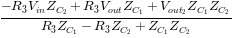

V_D = \frac{- R_{3} V_{in} Z_{C_2} + R_{3} V_{out} Z_{C_1} + V_{out_2} Z_{C_1} Z_{C_2}}{R_{3} Z_{C_1} - R_{3} Z_{C_2} + Z_{C_1} Z_{C_2}}


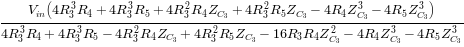

V_{out} = V_{in}*(4*R_3**3*R_4 + 4*R_3**3*R_5 + 4*R_3**2*R_4*Z_{C_3} + 4*R_3**2*R_5*Z_{C_3} - 4*R_4*Z_{C_3}**3 - 4*R_5*Z_{C_3}**3)/(4*R_3**3*R_4 + 4*R_3**3*R_5 - 4*R_3**2*R_4*Z_{C_3} + 4*R_3**2*R_5*Z_{C_3} - 16*R_3*R_4*Z_{C_3}**2 - 4*R_4*Z_{C_3}**3 - 4*R_5*Z_{C_3}**3)


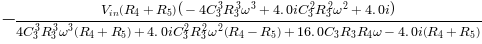

V_{out} = -V_{in}*(R_4 + R_5)*(-4*C_3**3*R_3**3*\omega**3 + 4.0*I*C_3**2*R_3**2*\omega**2 + 4.0*I)/(4*C_3**3*R_3**3*\omega**3*(R_4 + R_5) + 4.0*I*C_3**2*R_3**2*\omega**2*(R_4 - R_5) + 16.0*C_3*R_3*R_4*\omega - 4.0*I*(R_4 + R_5))


In [2]:
V_in, V_out, R1, R2, R3, R4, R5, C1, C2, C3 = spy.symbols('V_{in} V_{out} R_1 R_2 R_3 R_4 R_5 C_1 C_2 C_3'
                                                          , real = True, positives = True)
V_B, V_D, V_out2, omega = spy.symbols('V_B V_D V_{out_2} \omega', real=True, positives=True)
Z_C1, Z_C2, Z_C3 = spy.symbols('Z_{C_1} Z_{C_2} Z_{C_3}')

I1 = (V_in-V_B)/R1
I2 = (V_B-V_out)/R2
I3 = (V_B-V_out2)/Z_C3

V_B = spy.solve(I2+I3-I1, V_B)[0]
display(V_B)
print('V_B =', spy.latex(V_B))

I6 = (V_in - V_D)/Z_C1
I5 = (V_out2 - V_D)/R3
I2 = (V_out - V_D)/Z_C2

V_D = spy.solve(I2+I5-I6, V_D)[0]
display(V_D)
print('V_D =', spy.latex(V_D))

exp = ((V_B - V_out)/R2 - (V_out-V_D)/Z_C2).subs([(V_out2, V_out*R5/(R4+R5))])
V_out = spy.solve(exp, V_out)[0]

substitutions = [(R1, 2*R3), (R2, 2*R3), (Z_C1, 2*Z_C3), (Z_C2, 2*Z_C3)]
V_out = V_out.subs(substitutions)
display(V_out)
print('V_{out} =', V_out)

substitutions = [(Z_C3, 1/(1j*omega*C3))]
V_out = V_out.subs(substitutions).simplify()
display(V_out)
print('V_{out} =', V_out)

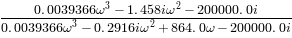

V_{out} = (0.0039366*\omega**3 - 1.458*I*\omega**2 - 200000.0*I)/(0.0039366*\omega**3 - 0.2916*I*\omega**2 + 864.0*\omega - 200000.0*I)


In [3]:
R_3 = 5e6
R_4 = 20e3
R_5 = 30e3
C_3 = 540e-12
Vin = 1
substitutions = [(R3, R_3), (R4, R_4), (R5, R_5), (C3, C_3), (V_in, Vin)]

V_out = V_out.subs(substitutions).simplify()
display(V_out)
print('V_{out} =', V_out)

In [4]:
N = 100
freq = np.logspace(0, 6, N)*2*np.pi
outs = np.zeros((N, 2))

for (i, f) in enumerate(freq):
    out = V_out.evalf(subs={omega:f})
    
    outs[i, 0] = abs(out)
    outs[i, 1] = float(spy.atan(spy.im(out)/spy.re(out)))

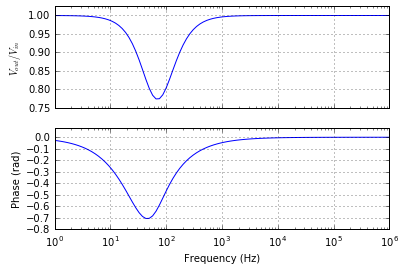

In [5]:
fig, axes = plt.subplots(2, sharex=True)
freq *= 1/(2*np.pi)
for i in range(2):
    axes[i].plot(freq, outs[:,i])
    axes[i].grid()
    axes[i].set_xscale('log')
    
    down, up = axes[i].get_ylim()
    axes[i].set_ylim(down, up+(up-down)*0.1)

axes[0].set_ylabel('$V_{out}/V_{in}$')
axes[1].set_ylabel('Phase (rad)')
axes[1].set_xlabel('Frequency (Hz)')
plt.show()

In [11]:
amplitude = outs[:,0]
derivative = np.diff(amplitude)
min_pos = derivative.argsort()
min_pos, max_pos = min_pos[0], min_pos[-1]

f = interp1d(derivative[min_pos:max_pos], freq[min_pos:max_pos])
freq_min = f(0)
#min_pos = amplitude.argmin()
#look_for = 1-(1-amplitude[min_pos])/np.sqrt(2)
#value = abs(amplitude[min_pos:]-look_for).argmin()+min_pos
#amp_value, freq_value = amplitude[value], freq[value]

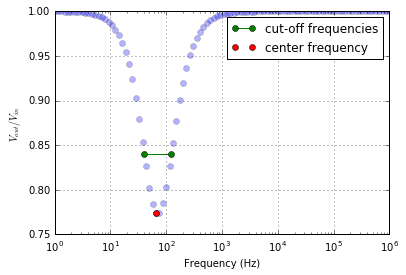

In [13]:
f = interp1d(freq, amplitude)
min_intensity = f(freq_min)
look_for = 1-(1-min_intensity)/np.sqrt(2)
pos = amplitude.argmin()

freq_left = freq[:pos]
freq_right = freq[pos:]

f_left = interp1d(amplitude[:pos], freq_left)
f_right = interp1d(amplitude[pos:], freq_right)

f_left = f_left(look_for)
f_right = f_right(look_for)

BW = f_right - f_left
Q = freq_min/BW
plt.plot(freq, amplitude, 'o',alpha=0.3)
plt.plot((f_left, f_right), (look_for, look_for), '-o', label='cut-off frequencies')
plt.plot(freq_min, min_intensity, 'o', label='center frequency')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$V_{out}/V_{in}$')
plt.legend()
plt.grid()

In [14]:
f_left, f_right, freq_min, BW, Q

(array(40.39636489811825),
 array(124.02422000234633),
 array(65.34924491890806),
 83.627855104228075,
 0.78142916421162778)

# Punto 2

In [2]:
Vout, V1, V2, VA, VB, VP, R1, R2, RG = spy.symbols('V_{out} V_1 V_2 V_A V_B V_P R_1 R_2 R_G', real = True, positive = True)

ex1 = (V2 - VP)/R1 - (VP-VA)/R2
VP = spy.solve(ex1, VP)[0]

ex2 = (V1 - VP)/R1 - (VP - VB)/R2
VB = spy.solve(ex2, VB)[0]

I1 = (V2 - VP)/R1
I2 = (V1 - VP)/R1
I3 = (Vout - VA)/R2

I5 = VB/R2

ex3 = I1 + I2 + I3 - I5
VA_ = spy.solve(ex3, VA)[0]

I4 = (VA - VB)/RG

ex4 = (I1 + I3 - I4).subs([(VA, VA_)])#.simplify()

Vout = spy.solve(ex4, Vout)[0]
display(Vout)

In [6]:
display(ex4.simplify().expand())